--- Starting Model Training & Evaluation Workflow ---
Loading training data from: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/train.csv
Training data loaded successfully.

--- 2. Data Exploration ---
DataFrame Head:
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 Na

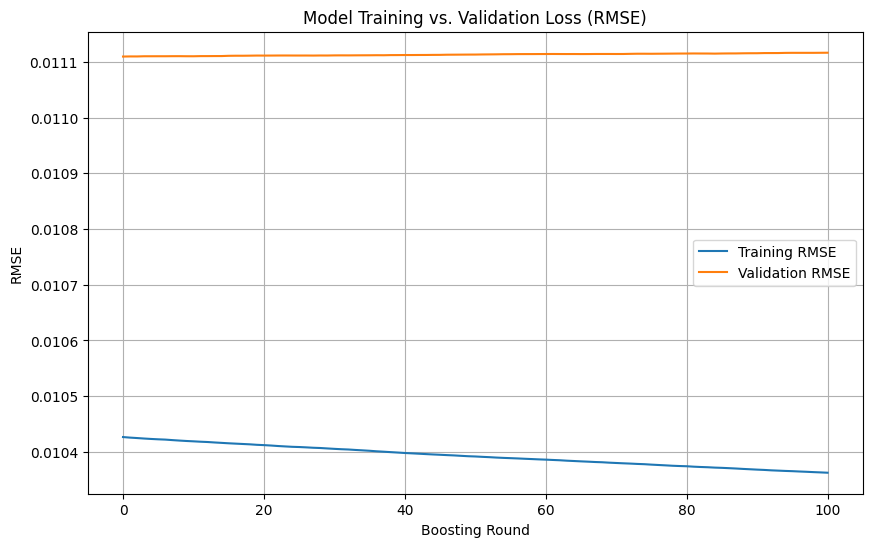


--- 8. Training Final Model on All Data ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 23
[LightGBM] [Info] Start training from score 0.000051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Final model training complete.
Saving final model to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/lgbm_model.pkl
Model saved successfully.
Saving final scaler to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/scaler.pkl
Scaler saved successfully.
Saving feature list to: /Users/rushilpatel/Downloads/hull-tactical-market-prediction/selected_features.txt
Feature list saved successfully.

--- Workflow Finished Successfully! ---


In [6]:
import pandas as pd
import lightgbm as lgb
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Configuration ---
# IMPORTANT: Make sure these paths are correct for your local setup.
DATA_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'
OUTPUT_PATH = '/Users/rushilpatel/Downloads/hull-tactical-market-prediction/'

TRAIN_FILE_PATH = os.path.join(DATA_PATH, 'train.csv')
MODEL_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'lgbm_model.pkl')
FEATURES_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'selected_features.txt')
SCALER_OUTPUT_PATH = os.path.join(OUTPUT_PATH, 'scaler.pkl')

def train_and_evaluate_model():
    """
    A comprehensive workflow to load data, explore it, train a regularized LightGBM model,
    and save the final artifacts.
    """
    print("--- Starting Model Training & Evaluation Workflow ---")

    # --- 1. Load Data ---
    try:
        print(f"Loading training data from: {TRAIN_FILE_PATH}")
        df_train = pd.read_csv(TRAIN_FILE_PATH)
        print("Training data loaded successfully.")
    except FileNotFoundError:
        print(f"ERROR: Training file not found at {TRAIN_FILE_PATH}")
        return

    # --- 2. Data Exploration ---
    print("\n--- 2. Data Exploration ---")
    print("DataFrame Head:")
    print(df_train.head())

    # --- 3. Feature Selection & Initial Preprocessing ---
    print("\n--- 3. Feature Selection & Initial Preprocessing ---")
    selected_features = [
        'M1', 'M5', 'M6', 'E1', 'E5', 'E7', 'I1', 'I5', 'I7',
        'P1', 'P5', 'P6', 'V1', 'V5', 'V8', 'V9',
        'S1', 'S5', 'S8', 'S10',
        'D1', 'D5', 'D8'
    ]
    target = 'market_forward_excess_returns'
    
    df_train.dropna(subset=[target], inplace=True)
    
    X = df_train[selected_features].ffill().bfill()
    y = df_train[target]

    # --- 4. Time-Series Split ---
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    # --- 5. Data Scaling (Standardization) ---
    print("\n--- 5. Scaling Features ---")
    scaler = StandardScaler()
    
    # Fit the scaler ONLY on the training data to prevent data leakage
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Convert scaled arrays back to DataFrames
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    print("Training and validation data have been scaled.")

    # --- 6. Model Training with STRONGER Regularization ---
    print("\n--- 6. Model Training with Stronger Regularization to Combat Overfitting ---")
    lgbm = lgb.LGBMRegressor(
        random_state=42,
        n_estimators=2000,
        learning_rate=0.01,
        # --- Parameters to reduce overfitting ---
        num_leaves=20,              # Reduced from 31
        min_child_samples=50,       # Increased from 30
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,              # Increased from 0.1 (L1 Regularization)
        reg_lambda=5.0              # Increased from 1.0 (L2 Regularization)
    )

    lgbm.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)],
             eval_metric='rmse',
             callbacks=[lgb.early_stopping(100, verbose=True), lgb.log_evaluation(100)])

    # --- 7. Analysis & Visualization ---
    print("\n--- 7. Model Analysis ---")
    
    # Plot Training vs. Validation Loss
    results = lgbm.evals_result_
    plt.figure(figsize=(10, 6))
    plt.plot(results['training']['rmse'], label='Training RMSE')
    plt.plot(results['valid_1']['rmse'], label='Validation RMSE')
    plt.title('Model Training vs. Validation Loss (RMSE)')
    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Feature Importance
    lgb.plot_importance(lgbm, max_num_features=25, figsize=(10, 10), importance_type='gain')
    plt.title('Top 25 Feature Importances (Gain)')
    plt.show()

    # --- 8. Final Model Training & Saving ---
    print("\n--- 8. Training Final Model on All Data ---")
    # First, create and fit a new scaler on the ENTIRE dataset
    final_scaler = StandardScaler()
    X_scaled = final_scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    # Now, train the final model on the entire scaled dataset
    final_model = lgb.LGBMRegressor(**lgbm.get_params())
    final_model.set_params(n_estimators=lgbm.best_iteration_)
    final_model.fit(X_scaled_df, y)
    print("Final model training complete.")

    # Save the final model
    print(f"Saving final model to: {MODEL_OUTPUT_PATH}")
    with open(MODEL_OUTPUT_PATH, 'wb') as f:
        pickle.dump(final_model, f)
    print("Model saved successfully.")
    
    # Save the final scaler
    print(f"Saving final scaler to: {SCALER_OUTPUT_PATH}")
    with open(SCALER_OUTPUT_PATH, 'wb') as f:
        pickle.dump(final_scaler, f)
    print("Scaler saved successfully.")

    # Save the feature list
    print(f"Saving feature list to: {FEATURES_OUTPUT_PATH}")
    with open(FEATURES_OUTPUT_PATH, 'w') as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    print("Feature list saved successfully.")
    print("\n--- Workflow Finished Successfully! ---")


if __name__ == '__main__':
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
    train_and_evaluate_model()

